In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

source = '../data/lendingclub/'

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(source + 'lending-club-subset.csv')
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format = True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(source + 'primaryMarketNotes_browseNotes_1-RETAIL.csv')

# print # of observations
print(f'{len(history)} historical loans')
print(f'{len(history)} current loans')

128334 historical loans
128334 current loans


In [7]:
# calculate % of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# see % paid for charged off vs fully paid loans
history.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.546541,0.278077,0.0,0.327761,0.514006,0.742090,1.490546
Fully Paid,105857.0,1.146904,0.089759,1.0,1.083836,1.132098,1.195798,1.623628


### Build baseline --> what would we get if we took a random decision

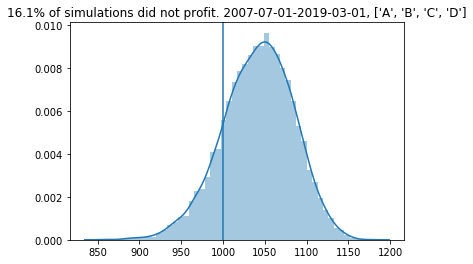

In [8]:
def simulate(n=10000, grades=['A','B','C','D'], 
             start_date='2007-07-01', 
             end_date='2019-03-01'):
    """
    What if you picked 40 random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((history['grade'].isin(grades)) & 
                 (history['issue_d'] >= start_date) &
                 (history['issue_d'] <= end_date))
    possible = history[condition]
    
    simulations = []
    for _ in tnrange(n):
        picks = possible.sample(40).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    plt.title(f'{percent}% of simulations did not profit. {start_date}-{end_date}, {grades}')

simulate()

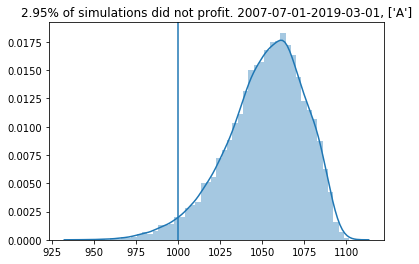

In [9]:
simulate(grades=['A'])

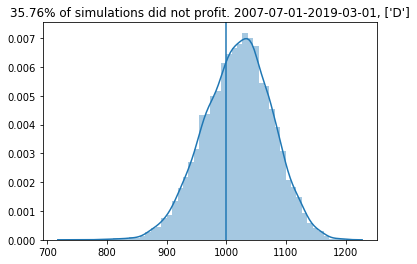

In [10]:
simulate(grades=['D'])

## Wrangle data
<br>
<li> Engineer data based features
<li> Remove features to avoid leakage
<li> Do 3-way split, train / validate / test

In [11]:
# Engineer date-based features

# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [12]:
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [13]:
# Train on the historical data.
# For features, use only the common columns shared by the historical & current data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')

features = list(common_columns)
target = 'loan_status'
X = history[features]
y = history[target]

In [14]:
# Do train/validate/test 3-way split

from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 108)
y_train shape (88334,)
X_val shape (20000, 108)
y_val shape (20000,)
X_test shape (20000, 108)
y_test shape (20000,)


## Show why accuracy is misleading with imbalanced classes

In [15]:
y_train.value_counts(normalize=True)

Fully Paid     0.824858
Charged Off    0.175142
Name: loan_status, dtype: float64

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.82485

## confusion matrix for majority class baseline model

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

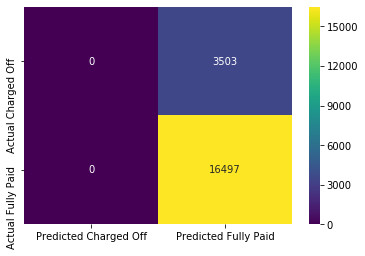

In [18]:
plot_confusion_matrix(y_val, y_pred);

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00      3503
  Fully Paid       0.82      1.00      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.82      0.75     20000



## Get AUC score

In [28]:
from sklearn.metrics import roc_auc_score

# What if we predicted 100% probability of the positive class for every prediction?
# This is like the majority class baseline, but with predicted probabilities,
# instead of just discrete classes.
# VERY IMPORTANT — Use predicted probabilities with ROC AUC score!
# Because, it's a metric of how well you rank/sort predicted probabilities.
y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

0.5

In [29]:
# ROC AUC is 0.50 by definition when predicting any constant probability value
y_pred_proba = np.full_like(y_val, fill_value=0)
roc_auc_score(y_val, y_pred_proba)

0.5

In [30]:
y_pred_proba = np.full_like(y_val, fill_value=0.50)
roc_auc_score(y_val, y_pred_proba)

0.5

In [31]:
y_val.value_counts()

Fully Paid     16497
Charged Off     3503
Name: loan_status, dtype: int64

In [32]:
# Plot ROC curve
fpr, tpr, thresholds = roc_auc_score(y_val=='Charged Off', y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

TypeError: cannot unpack non-iterable numpy.float64 object

## Fit a model

count missing values

In [33]:
null_counts = X_train.isnull().sum().sort_values(ascending=False)
null_counts.reset_index()

,index,0
0,member_id,88334
1,sec_app_mths_since_last_major_derog,87855
2,sec_app_revol_util,86968
3,sec_app_chargeoff_within_12_mths,86954
4,sec_app_fico_range_low,86954
5,sec_app_collections_12_mths_ex_med,86954
6,sec_app_mort_acc,86954
7,sec_app_fico_range_high,86954
8,sec_app_num_rev_accts,86954
9,revol_bal_joint,86954


In [34]:
many_nulls = null_counts[:73].index
print(list(many_nulls))

['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_chargeoff_within_12_mths', 'sec_app_fico_range_low', 'sec_app_collections_12_mths_ex_med', 'sec_app_mort_acc', 'sec_app_fico_range_high', 'sec_app_num_rev_accts', 'revol_bal_joint', 'sec_app_inq_last_6mths', 'sec_app_earliest_cr_line', 'sec_app_open_act_il', 'sec_app_open_acc', 'annual_inc_joint', 'dti_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 'mths_since_rcnt_il', 'open_il_12m', 'inq_last_12m', 'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'open_act_il', 'open_acc_6m', 'total_cu_tl', 'inq_fi', 'all_util', 'open_il_24m', 'total_bal_il', 'mths_since_last_delinq', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 'avg_cur_bal', 'num_accts_ever_120_pd', 'num_tl_op_past_12m', 'total_il_high_credit_limit', 'tot_hi_cred_lim', 'tot_cur_bal', 'num_tl

In [35]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

In [44]:
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

Wall time: 7.57 s


In [40]:
accuracy_score(y_val, y_pred)

0.82485

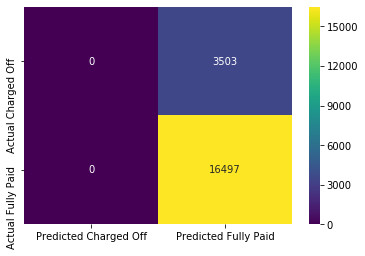

In [41]:
plot_confusion_matrix(y_val, y_pred);

In [42]:
print(classification_report(y_val, y_pred))

C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00      3503
  Fully Paid       0.82      1.00      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.82      0.75     20000



In [45]:
roc_auc_score(y_val, y_pred_proba)

0.5

## Visualize the ROC curve by plotting true positive rate vs false positive rate at varying thresholds

In [46]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))
    
    # Show confusion matrix & classification report
    plot_confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.05));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

In [47]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

              precision    recall  f1-score   support

           0       1.00      0.29      0.45        96
           1       0.06      1.00      0.11         4

    accuracy                           0.32       100
   macro avg       0.53      0.65      0.28       100
weighted avg       0.96      0.32      0.44       100



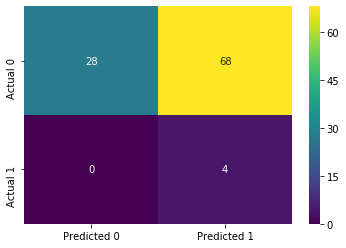

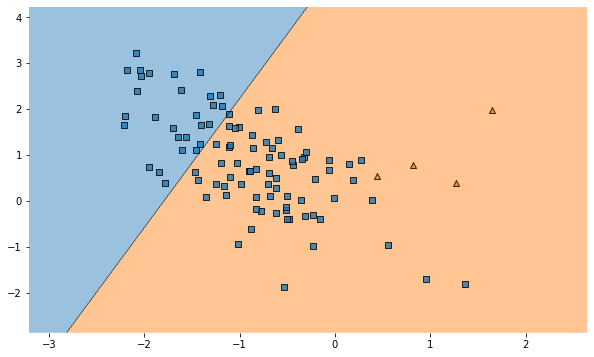

In [53]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions


#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = {0: 1, 1: 1000}

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);